# Jupyter Notebook interattivo per modellare l' anomalia di gravita' dovuta al Corpo di Ivrea

### TASK:

Studiare l'anomalia del Corpo di Ivrea  a basso ed alto dettaglio spaziale e con soluzioni analitiche e numeriche

### WORKFLOW:

(1) Leggere e visualizzare i dati di anomalia gravimetrica a bassa risoluzione

    (1.2) Modellare l'anomalia di gravita' del Corpo di Ivrea con una sfera sepolta (soluzione analitica)

    (1.3) Modellare l'anomalia di gravita' del Corpo di Ivrea con gli elementi finiti (soluzione numerica)

(2) Leggere e visualizzare i dati di anomalia gravimetrica ad alta risoluzione

    (2.1) Modellare l'anomalia di gravita' del Corpo di Ivrea con una sfera sepolta (soluzione analitica)

    (2.3) Modellare l'anomalia di gravita' del Corpo di Ivrea con gli elementi finiti (soluzione numerica)



### Import libraries

In [1]:
# Per il calcolo numerico
import numpy as np

# Per la presentazione grafica dei risultati
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Per le parti interattive del Notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets

#Per visualizzare immagini
from IPython.display import Image
import matplotlib.image as image 



### Prospezione Gravimetrica

Con il termine "prospezione gravimetrica" si intende quell' insieme di indagini geofisiche atte alla misurazione in superficie di anomalie di gravita'. Tali anomalie si possono mettere in relazione a eterogeneita' di densita' delle rocce del sottosuolo, come illustrato nella figura sottostante.

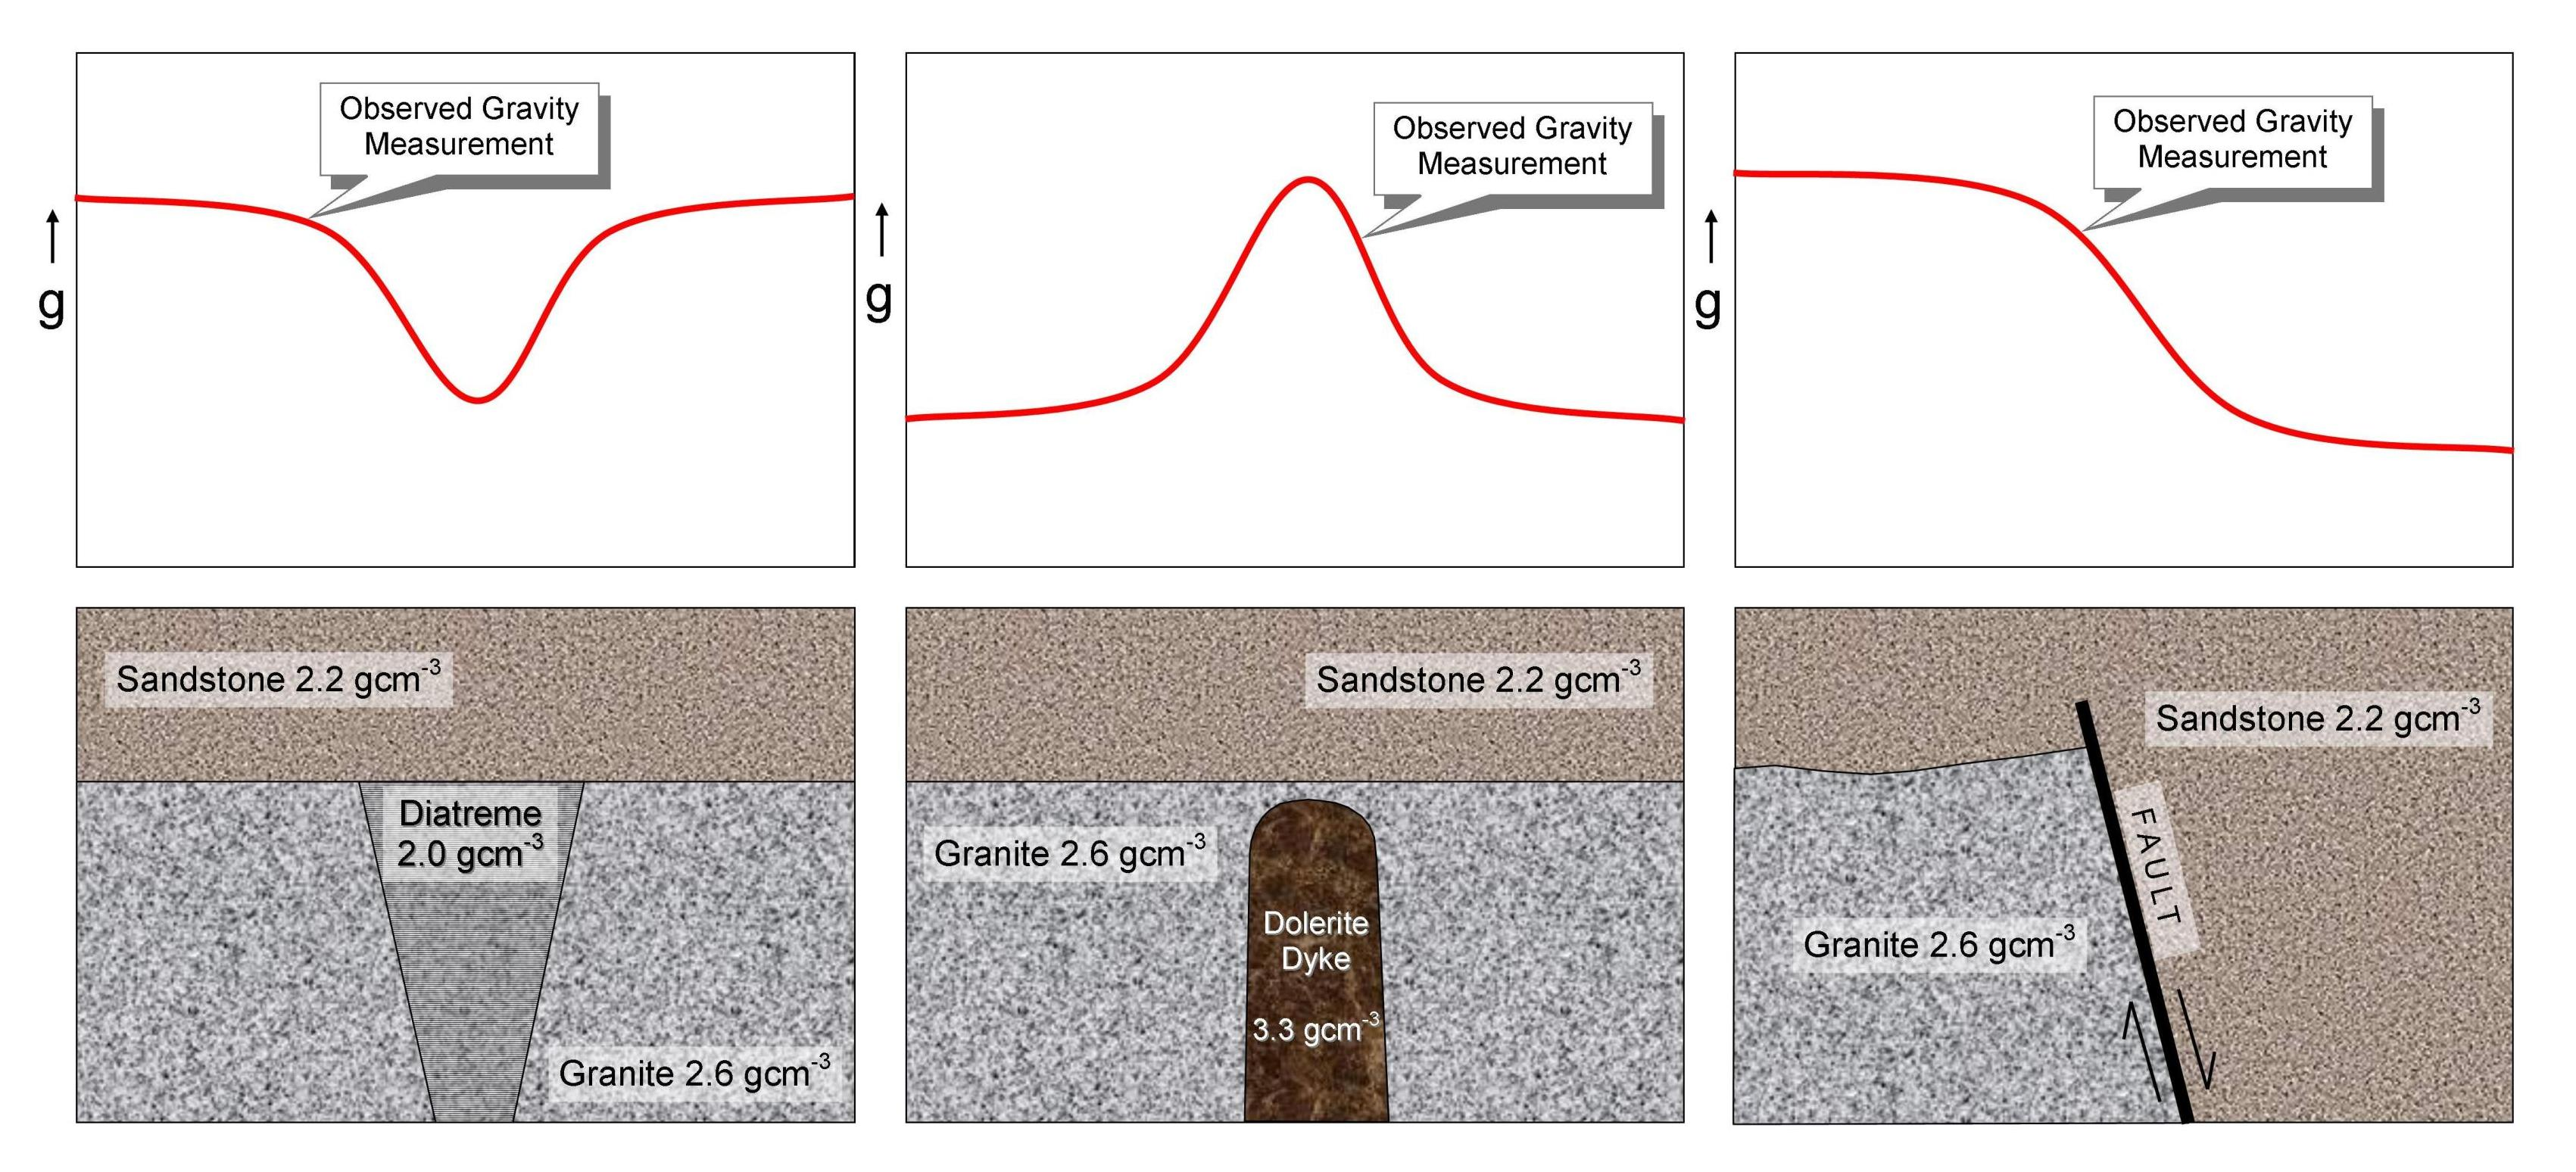

In [2]:
Image("img/gravimetry01.jpg",width=8000)

(from https://petgeo.weebly.com/exploration-techniques.html)

### Definizioni

In [3]:
#
# Variabili utilizzate nel Notebook per l'analisi
#
GRAVITY_DATA_LOW_RES="input/gravity_Ivrea_Low_Res"
GRAVITY_DATA_HIGH_RES="input/gravity_Ivrea_High_Res"
#
#
# Additional parameters

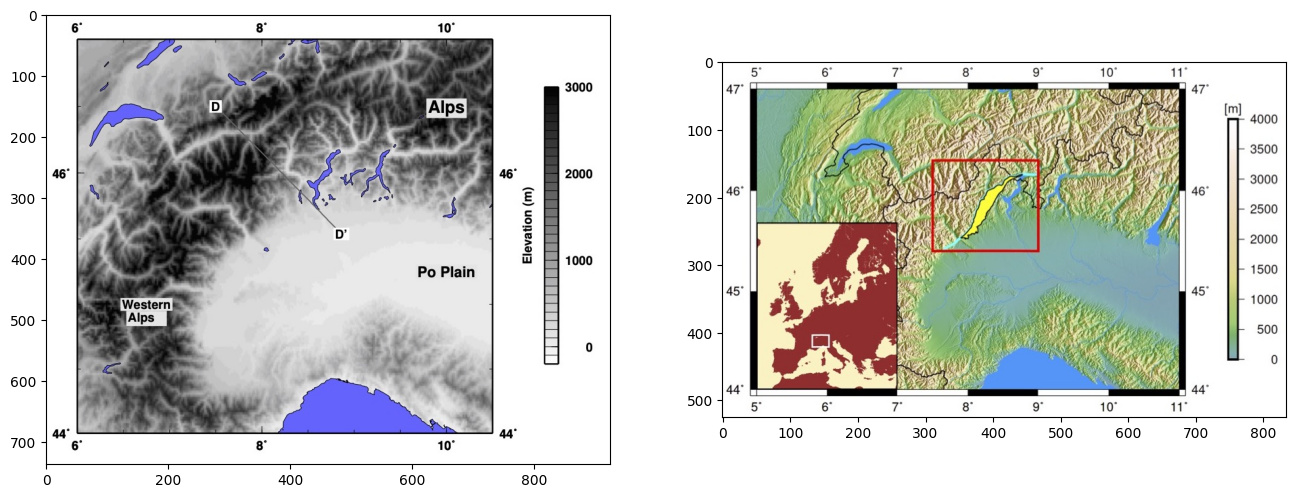

In [4]:
im1=plt.imread("img/ivrea_map.jpg")
im2=plt.imread("img/ivrea_scarponi_2020.jpg")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(im1)
ax2.imshow(im2)
plt.show()



Mappa del Nord Italia con il profilo DD' lungo cui faremo la nostra analisi. Il profilo attraversa il corpo di Ivrea ortogonalmente al suo asse maggiore (corpo giallo nella figura di sinistra). Figura di sinistra da: Scarponi et al. (2020) Geophys. J. Int., 222, 1977–1991 doi: 10.1093/gji/ggaa263.

## (1) Leggere e visualizzare i dati di anomalia gravimetrica a bassa risoluzione

Leggiamo ora da un file di input i dati osservati a bassa risoluzione. Per noi i dati osservati saranno l'anomalia di Bouguer lungo il profilo DD' estratta da un database globale (cioe' che copre tutto il mondo) di anomalie gravimetriche. La risoluzione spaziale in questo caso e' 2 minuti di arco.


DATABASE GLOBALE: Bonvalot, S., Balmino, G., Briais, A., M. Kuhn, Peyrefitte, A., Vales N., Biancale, R., Gabalda, G., Reinquin, F., Sarrailh, M., 2012. World Gravity Map. Commission for the Geological Map of the World. Eds. BGI-CGMW-CNES-IRD, Paris



Found 16 gravity measurements ...


<Figure size 640x480 with 0 Axes>

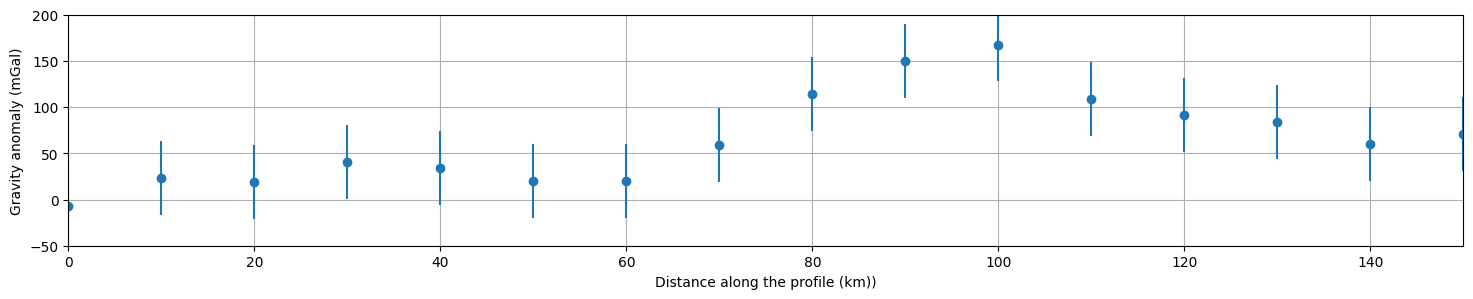

<Figure size 640x480 with 0 Axes>

In [5]:
statfile = open(GRAVITY_DATA_LOW_RES, 'r')
stat_x = []
stat_grav = []


linestoken=statfile.readlines()
nstat=0
for x in linestoken:
    grav0=float(x.split()[3])+45.0
    x0=float(x.split()[2])
    stat_x.append(x0)
    stat_grav.append(grav0)
    nstat += 1
    
print('Found', nstat, 'gravity measurements ...')

plt.figure(figsize=(18,3))
plt.errorbar(stat_x,stat_grav, yerr=40, fmt='o')
plt.grid()
plt.ylabel('Gravity anomaly (mGal)')
plt.xlim(0,150)
plt.ylim(-50,200)
plt.xlabel('Distance along the profile (km))')
plt.figure()

## (1.2) Modellare l'anomalia di gravita' del Corpo di Ivrea con una sfera sepolta (soluzione analitica)

Cercheremo ora di modellare l' anomalia di gravita' a bassa risoluzione con una sfera sepolta.  Cercheremo di trovare la combinazione migliore dei parametri che rappresentano la sfera sepolta, ovvero contrasto di densita', Raggio e posizione nel piano x-z della sfera, per riuscire a riprodurre i dati osservati a bassa risoluzione (aggiunti nella figura come punti arancioni con le barre di errore).


FORMULA:

$$ \Delta g(x) = \frac{4}{3}\pi G R^3 \delta\rho \frac{z}{ [(x-x_c)^2+z^2]^{3/2} } $$

VARIABILI:

$\Delta g(x)$, anomalia di gravita' lungo l'asse x (profilo gravimentrico) da calcolare

$\delta\rho$, differenza di densita' tra sfera e rocce incassanti

$R$, raggio della sfera

$z$, profondita' del centro della sfera

$x_c$, coordinata x della proiezione del centro della sfera in superfice 


In [6]:


print('Fit alle osservazioni dell\' anomalia di gravita\' dovuta ad una sfera sepolta (unita\' MKS):')

@interact(drho=widgets.FloatSlider(min=-1500, max=1500, step=10, value=0,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          R=widgets.FloatSlider(min=0.001, max=40, step=0.1, value=1,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          z=widgets.FloatSlider(min=0.001, max=40, step=0.1, value=10,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          xc=widgets.FloatSlider(min=0.001, max=150, step=1, value=50,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')))

def npa_dg_sphere_w_obs(drho=100, R=5, z=10, xc=50):
    G=6.67e-11  # Metric system is MKS -- distances in meters
    statfile = open(GRAVITY_DATA_LOW_RES, 'r')
    x_obs = []
    dg_obs = []


    linestoken=statfile.readlines()
    nstat=0
    for x in linestoken:
        grav0=float(x.split()[3])+45.0
        x0=float(x.split()[2])
        x_obs.append(x0)
        dg_obs.append(grav0)
        nstat += 1
    
    dg_err=40
    R0=R*1000
    z0=z*1000
    xc0=xc*1000
    
    cost=(4.0/3.0)*3.1415*G*(R0**3)*drho
    x_all = []
    dg_all = []
    dx=1
    x=0
    i=0
    while i < 160:
        x+=1
        x_all.append(x)
        x0=x*1000
        dg= ( cost * (z0)/( ((x0-xc0)**2 + z0**2)**(1.5) ) ) * 100000.0
        dg_all.append(dg)
        i+=1

    depth=-1.0*z
    fig, (ax1,ax2) = plt.subplots(2,figsize=(15,6))
    ax1.plot(x_all,dg_all)
    ax1.errorbar(x_obs, dg_obs, yerr=dg_err, fmt='o')
    ax1.grid()
    ax1.set_ylabel('Gravity anomaly (mGal)')
    ax1.set_xlim(0,160)
    ax1.set_ylim(-50,200)
    Drawing_colored_circle = plt.Circle(( xc , depth ), R ) 
    ax2.add_artist( Drawing_colored_circle )
    ax2.grid()
    ax2.set_ylabel('Depth (km)')
    ax2.set_xlabel('x (km)')
    ax2.set_xlim(0,160)
    ax2.set_ylim(-40,0)
    plt.figure()
    
    return





Fit alle osservazioni dell' anomalia di gravita' dovuta ad una sfera sepolta (unita' MKS):


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='drho', layout=Layout(height…

## (1.3) Modellare l'anomalia di gravita' del Corpo di Ivrea con gli elementi finiti (soluzione numerica)

Adesso cercheremo di trovare la combinazione migliore di N elementi infinitesimali (per noi "piccoli cubi di raggio 5km") nel piano x-z, per riuscire a riprodurre i dati osservati (aggiunti nella figura come punti arancioni con le barre di errore). Assumeremo il contrasto di densita' come ottenuto in precedenza (800 kg/$m^2$). Rispetto all' esperienza precedente, potremmo utilizzare fino a 6x32=192 elementi di dimensione 5x5 km, che coprono tutto il profilo e, in profondita', fino a 30 km. (Nel nostro caso, l' anomalia di ogni elemento e' calcolata dalla sfera equivalente di raggio 4 km)

    
FORMULA (dalle dispense della prof.ssa Pasquero, Eq 1.41):

$$ \Delta g(x) = G \sum_N {\delta\rho}_i \frac{z_i}{ [(x-x_i)^2+z_i^2]^{3/2} } $$

VARIABILI:

$\Delta g(x)$, anomalia di gravita' lungo l'asse x (profilo gravimentrico) da calcolare

${\delta\rho}_i$, differenza di densita' tra i-esimo volume infinitesimale e rocce incassanti

$z_i$ profondita' del i-esimo volume infinitesimale

$x_i$, coordinata x del i-esimo volume infinitesimale

$N$, numero di elementi infinitesimali



In [7]:
from ipywidgets import GridspecLayout
from ipywidgets import ToggleButton

def create_expanded_button(description, button_style):
    return ToggleButton(value=False,
                        description=description, 
                        disabled=False,
                        button_style=button_style, 
                        layout=Layout(height='auto', width='auto'))

dg_err=40

#plt.figure(figsize=(18,3))
#plt.errorbar(stat_x, stat_grav, yerr=dg_err, fmt='o')
#plt.grid()
#plt.ylabel('Gravity anomaly (mGal)')
#plt.xlim(0,160)
#plt.ylim(-50,200)
#plt.xlabel('x (km)')
#plt.show()

grid = GridspecLayout(6, 32)

for i in range(6):
    for j in range(32):
        grid[i, j] = create_expanded_button('IB', '')
#grid

Fit alle osservazioni dell' anomalia di gravita' dovuta a N elementi infinitesimi (unita' MKS):


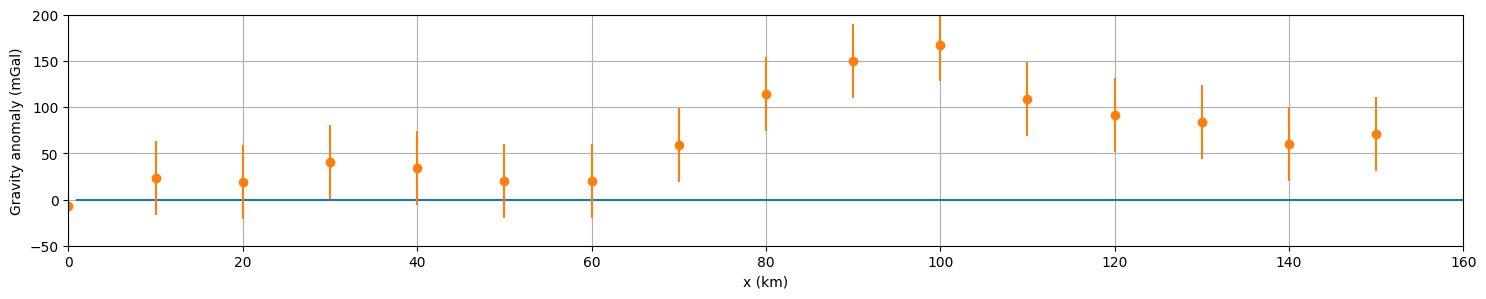

GridspecLayout(children=(ToggleButton(value=False, description='IB', layout=Layout(grid_area='widget001', heig…

In [8]:

print('Fit alle osservazioni dell\' anomalia di gravita\' dovuta a N elementi infinitesimi (unita\' MKS):')


G=6.67e-11  # Metric system is MKS -- distances in meters

drho=800

#
R0=4000.0
cost=(4.0/3.0)*3.1415*G*(R0**3)*drho
#

x_all = []
dg_all = []
dx=1
x=0
i=0
while i < 160:
    x+=1
    x0=x*1000                # X-coordinates in meters
    x_all.append(x0/1000)    # Append X-coordinates in Kilometers for plotting purposes
    dg0=0
    n_elem_sele=0
    j=0
    while j < 6:
        z0=4000+j*5000
        k=0
        while k < 32:
            x1=2500+k*5000
            if grid[j,k].value == True:
                n_elem_sele+=1
                #print(grid[j,k].value)
                dg0 = dg0 + ( cost * (z0)/( ((x0-x1)**2 + z0**2)**(1.5) ) ) * 100000.0
                #print(dg)
            k+=1
        j+=1
    dg = dg0
    dg_all.append(dg)
    i+=1

    

plt.figure(2,figsize=(18,3))
plt.plot(x_all,dg_all)
plt.errorbar(stat_x, stat_grav, yerr=dg_err, fmt='o')
plt.grid()
plt.ylabel('Gravity anomaly (mGal)')
plt.xlim(0,160)
plt.ylim(-50,200)
plt.xlabel('x (km)')
plt.show()
grid

## (2) Leggere e visualizzare i dati di anomalia gravimetrica ad alta risoluzione

Leggiamo ora da un file di input i dati osservati alta risoluzione. Per noi i dati osservati saranno l'anomalia di Bouguer lungo il profilo DD' Estratta dalle figure del lavoro:

Scarponi et al. (2020) New gravity data and 3-D density model constraints on the Ivrea
Geophysical Body (Western Alps), Geophys. J. Int., 222, 1977–1991 doi: 10.1093/gji/ggaa263

La nostra risoluzione spaziale potrebbe essere inferiore ad 1 km. Noi assumiamo sia tra 3-4 km. Non possiamo essere sicuri perche' i dati originali sono "restricted" e non si possono analizzare.

Found 33 gravity measurements ...


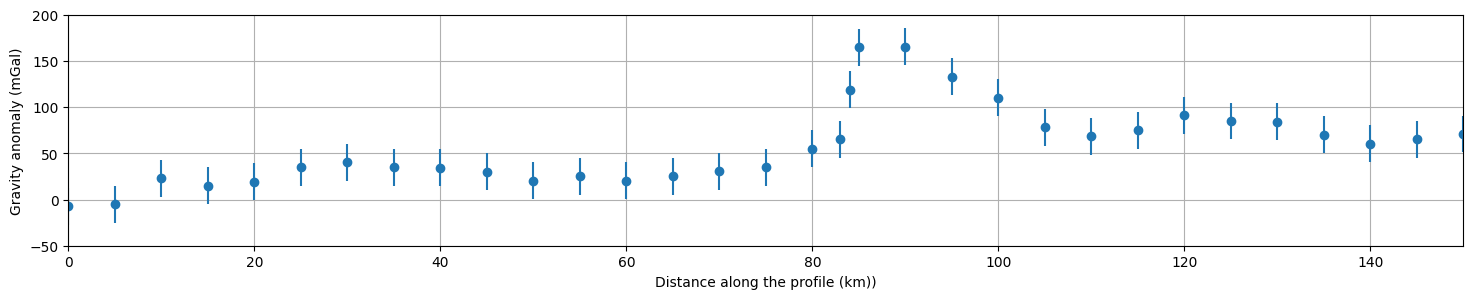

In [9]:
statfile = open(GRAVITY_DATA_HIGH_RES, 'r')
stat_x = []
stat_grav = []


linestoken=statfile.readlines()
nstat=0
for x in linestoken:
    grav0=float(x.split()[1])+45.0
    x0=float(x.split()[0])
    stat_x.append(x0)
    stat_grav.append(grav0)
    nstat += 1
    
print('Found', nstat, 'gravity measurements ...')

plt.figure(figsize=(18,3))
#plt.plot(stat_x,stat_grav)
plt.errorbar(stat_x,stat_grav, yerr=20, fmt='o')
plt.grid()
plt.ylabel('Gravity anomaly (mGal)')
plt.xlim(0,150)
plt.ylim(-50,200)
plt.xlabel('Distance along the profile (km))')
plt.show()

## (2.1) Modellare l'anomalia di gravita' del Corpo di Ivrea con una sfera sepolta (soluzione analitica)

Cercheremo ora di modellare l' anomalia di gravita' ad alta risoluzione con una sfera sepolta, come fatto al punto (1.2)

In [10]:


print('Fit alle osservazioni dell\' anomalia di gravita\' dovuta ad una sfera sepolta (unita\' MKS):')

@interact(drho=widgets.FloatSlider(min=-1500, max=1500, step=10, value=0,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          R=widgets.FloatSlider(min=0.001, max=40, step=0.1, value=1,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          z=widgets.FloatSlider(min=0.001, max=40, step=0.1, value=10,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          xc=widgets.FloatSlider(min=0.001, max=150, step=1, value=50,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')))

def npa_dg_sphere_w_obs(drho=100, R=5, z=10, xc=50):
    G=6.67e-11  # Metric system is MKS -- distances in meters
    statfile = open(GRAVITY_DATA_HIGH_RES, 'r')
    x_obs = []
    dg_obs = []


    linestoken=statfile.readlines()
    nstat=0
    for x in linestoken:
        grav0=float(x.split()[1])+45.0
        x0=float(x.split()[0])
        x_obs.append(x0)
        dg_obs.append(grav0)
        nstat += 1
    
    dg_err=40
    R0=R*1000
    z0=z*1000
    xc0=xc*1000
    
    cost=(4.0/3.0)*3.1415*G*(R0**3)*drho
    x_all = []
    dg_all = []
    dx=1
    x=0
    i=0
    while i < 160:
        x+=1
        x_all.append(x)
        x0=x*1000
        dg= ( cost * (z0)/( ((x0-xc0)**2 + z0**2)**(1.5) ) ) * 100000.0
        dg_all.append(dg)
        i+=1

    depth=-1.0*z
    fig, (ax1,ax2) = plt.subplots(2,figsize=(15,6))
    ax1.plot(x_all,dg_all)
    ax1.errorbar(x_obs, dg_obs, yerr=dg_err, fmt='o')
    ax1.grid()
    ax1.set_ylabel('Gravity anomaly (mGal)')
    ax1.set_xlim(0,160)
    ax1.set_ylim(-50,200)
    Drawing_colored_circle = plt.Circle(( xc , depth ), R ) 
    ax2.add_artist( Drawing_colored_circle )
    ax2.grid()
    ax2.set_ylabel('Depth (km)')
    ax2.set_xlabel('x (km)')
    ax2.set_xlim(0,160)
    ax2.set_ylim(-40,0)
    plt.figure()
    
    return





Fit alle osservazioni dell' anomalia di gravita' dovuta ad una sfera sepolta (unita' MKS):


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='drho', layout=Layout(height…

## (2.3) Modellare l'anomalia di gravita' del Corpo di Ivrea con gli elementi finiti (soluzione numerica

Adesso cercheremo di trovare la combinazione migliore di N elementi infinitesimali (per noi "piccoli cubi di raggio 5km") nel piano x-z, per riuscire a riprodurre i dati osservati (aggiunti nella figura come punti arancioni con le barre di errore), come nel punto (1.3)

In [11]:
from ipywidgets import GridspecLayout
from ipywidgets import ToggleButton

def create_expanded_button(description, button_style):
    return ToggleButton(value=False,
                        description=description, 
                        disabled=False,
                        button_style=button_style, 
                        layout=Layout(height='auto', width='auto'))

#plt.figure(figsize=(18,3))
#plt.errorbar(stat_x, stat_grav, yerr=dg_err, fmt='o')
#plt.grid()
#plt.ylabel('Gravity anomaly (mGal)')
#plt.xlim(0,160)
#plt.ylim(-50,200)
#plt.xlabel('x (km)')
#plt.figure()
#plt.show()

grid = GridspecLayout(6, 32)

for i in range(6):
    for j in range(32):
        grid[i, j] = create_expanded_button('IB', '')
#grid

Fit alle osservazioni dell' anomalia di gravita' dovuta a N elementi infinitesimi (unita' MKS):


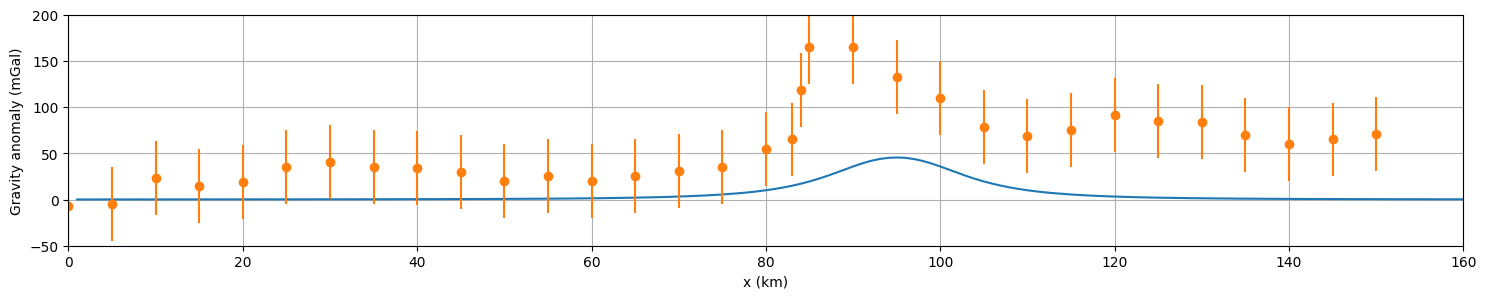

GridspecLayout(children=(ToggleButton(value=False, description='IB', layout=Layout(grid_area='widget001', heig…

In [13]:

print('Fit alle osservazioni dell\' anomalia di gravita\' dovuta a N elementi infinitesimi (unita\' MKS):')


G=6.67e-11  # Metric system is MKS -- distances in meters

drho=800
finite_element_side=5000    # Lunghezza del lato di un elemento finito, in metri

#
R0=(4./5.)*finite_element_side
cost=(4.0/3.0)*3.1415*G*(R0**3)*drho
#

x_all = []
dg_all = []
dx=1
x=0
i=0
while i < 160:
    x+=1
    x0=x*1000                # X-coordinates in meters
    x_all.append(x0/1000)    # Append X-coordinates in Kilometers for plotting purposes
    dg0=0
    n_elem_sele=0
    j=0
    while j < 6:
        z0=R0+j*finite_element_side
        k=0
        while k < 32:
            x1=(finite_element_side/2)+k*finite_element_side
            if grid[j,k].value == True:
                n_elem_sele+=1
                #print(grid[j,k].value)
                dg0 = dg0 + ( cost * (z0)/( ((x0-x1)**2 + z0**2)**(1.5) ) ) * 100000.0
                #print(dg)
            k+=1
        j+=1
    dg = dg0
    dg_all.append(dg)
    i+=1

    

plt.figure(2,figsize=(18,3))
plt.plot(x_all,dg_all)
plt.errorbar(stat_x, stat_grav, yerr=dg_err, fmt='o')
plt.grid()
plt.ylabel('Gravity anomaly (mGal)')
plt.xlim(0,160)
plt.ylim(-50,200)
plt.xlabel('x (km)')
plt.show()
grid

### Risultato ottenuto con dati simili

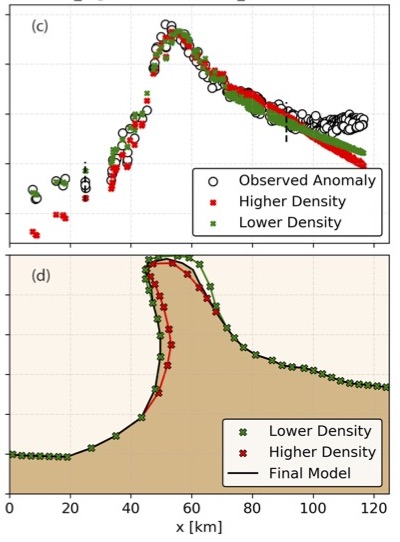

In [15]:
Image("img/ivrea_geophysical_body_from_scarponi_et_al_2020.jpg",width=500)

(Scarponi et al. (2020) Geophys. J. Int., 222, 1977–1991 doi: 10.1093/gji/ggaa263)

In [16]:
%load_ext watermark
%watermark -v -p numpy,matplotlib,ipywidgets

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.9.0

numpy     : 1.24.2
matplotlib: 3.6.3
ipywidgets: 8.0.4

